In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
import pyBigWig as bw
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pylab
import seaborn as sns
from sklearn.datasets import make_blobs
import colorcet as cc
import bean as be
from bean.preprocessing.utils import get_accessibility_guides

In [2]:
plt.style.use('default')
plt.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams['pdf.fonttype'] = 42 

In [3]:
bwIn = bw.open("../../resources/accessibility/ENCFF262URW.hg19.bw")
sublibraries=["SubA_Q5", "SubB_Q5", "SubC_Q5", "SubC_Q5U", "SubD_Q5", "SubD_Q5U",]

In [4]:
ctrl_screens = {}

In [5]:
def _format_special_chars(str_series):
    str_series = str_series.map(lambda s: s.replace("+", '_').replace("'", "_").replace(" ", '-'))
    return(str_series)


def _format_endo_screen(screen):
    screen.uns['allele_counts'] = screen.uns['allele_counts'].loc[screen.uns['allele_counts'].allele.map(str)!=""]
    screen.samples["rep"] = screen.samples.index.map(lambda s: s.rsplit("_")[-1])
    screen.layers['X_bcmatch'] = screen.X.astype(float)
    if 'name' in screen.guides.columns:
        screen.guides = screen.guides.set_index("name")
    screen.samples['rep'] = screen.samples.index.map(lambda s: s.rsplit("_")[-1])
    screen_adata = screen[:,screen.samples.rep != "Ctrl"].copy()
    ctrl_adata = screen[:,screen.samples.rep == "Ctrl"].copy()
    _, screen_adata.uns['sig_allele_counts'] = be.annotate.filter_alleles.filter_alleles(screen_adata, ctrl_adata, filter_each_sample = True, run_parallel=True, odds_ratio_thres=5)
    return screen_adata, ctrl_adata
    
def _format_guide_reporter_screen(screen):
    screen.guides.index = _format_special_chars(screen.guides.index)
    screen.uns['allele_counts'].guide = _format_special_chars(screen.uns['allele_counts'].guide)
    return screen

def load_data(sublib):
    endo = be.read_h5ad(f"../../results/mapped/minitiling/endo/{sublib}.h5ad")
    endo, ctrl = _format_endo_screen(endo)
    ctrl_screens[sublib] = ctrl
    reporter = be.read_h5ad(f"../../results/mapped/minitiling/guide_reporter/bean_count_{sublib}.h5ad")
    reporter = _format_guide_reporter_screen(reporter)
    
    guide_depth = reporter[endo.guides.index, :].X
    endo.layers['repscreen_X'] = guide_depth
    endo.layers['X_bcmatch'] = endo.layers['repscreen_X']/endo.layers['repscreen_X'].sum(axis=0)*endo.X
    endo.guides = endo.guides.merge(reporter.guides.reset_index()[['name','sequence','guide_len']],
                                            on='name', how='left')
    return(endo, reporter)

### Format guide_reporter screen

In [6]:
def get_guide_rel_pos(screen, row):
    '''
    Convert rel_pos from coordinate relative to reporter sequence start to guide sequence start.
    '''
    guide_len = screen.guides.loc[row.guide, "guide_len"]
    guide_start_pos = 32-6-guide_len
    edits = []
    for edit in deepcopy(row.allele.edits):
        edit.rel_pos -= guide_start_pos
        if edit.rel_pos < 0 or edit.rel_pos > guide_len: continue
        edit.pos = edit.rel_pos
        if edit.ref_base == "A" and edit.alt_base == "G":
            edits.append(edit)
    return(be.Allele(edits))

def filter_reporter_allele(reporter_screen, reporter_df):
    '''
    Convert rel_pos from coordinate relative to reporter sequence start to guide sequence start.
    '''
    reporter_sig = reporter_df.copy()
    reporter_sig['allele_conv'] = reporter_sig.apply(lambda row:get_guide_rel_pos(reporter_screen, row), axis=1)
    reporter_sig = reporter_sig.loc[reporter_sig.allele_conv.map(str) != ""]
    reporter_sig = reporter_sig[['guide', 'allele_conv'] + reporter_screen.samples.index.tolist()]
    reporter_sig = reporter_sig.rename(columns={'allele_conv' : 'allele'}).fillna(0)
    reporter_sig = reporter_sig.groupby(['guide', 'allele']).sum().reset_index()
    return(reporter_sig)


def get_reporter_edit_rates(reporter_screen, within_spacer_only=False):
    '''
    Get edit allele- and nt-level editing rate
    '''
    if within_spacer_only:
        reporter_screen.uns['allele_counts_filtered'] = filter_reporter_allele(reporter_screen, reporter_screen.uns['allele_counts'])
        allele_df_key='allele_counts_filtered'
    else:
        allele_df_key='allele_counts'
    reporter_allele_rate = reporter_screen.get_normalized_allele_counts(reporter_screen.uns[allele_df_key])
    reporter_edits = reporter_screen.get_edit_from_allele(allele_df_key, return_result=True)
    reporter_edit_rate = reporter_screen.get_normalized_allele_counts(reporter_edits)
    return reporter_allele_rate, reporter_edit_rate


### Format endo screen

In [7]:
lib_direction={"SubA_Q5":"pos", "SubB_Q5":"pos", "SubC_Q5":"neg", "SubC_Q5U":"neg","SubD_Q5":"neg", "SubD_Q5U":"neg"}
revmap = {"A": "T", "C": "G", "T": "A", "G": "C", "-": "-", "N":"N"}

def filter_endo_alleles(row, guide_df, lib):
    '''
    Adjust the allele by 1) reverse complementing edits in negative template, 2) adjusting relative position
    '''
    strand = row.guide.rsplit("_")[-1]
    assert strand in ["pos", "neg"] and lib_direction[lib] in ["pos", "neg"], ValueError(f"Invalid strand direction in {strand} or {lib_direction[lib]}")
    guide_len = guide_df.loc[guide_df.name == row.guide, 'guide_len'].item()
    edits = []
    for edit in deepcopy(row.allele.edits):
        if strand == lib_direction[lib]:
            edit = _adjust_forward_edit(edit, guide_len)
        if strand != lib_direction[lib]:
            edit = _reverse_edit(edit, guide_len)
        if strand == "neg":
            edit.strand = '-'
        edits.append(edit)
    return(be.Allele(edits))

def _adjust_forward_edit(edit, guide_len):
    if guide_len != 20:
        edit.rel_pos -= 1
        edit.pos -= 1
    return edit

def _reverse_edit(edit, guide_len):
    edit.ref_base = revmap[edit.ref_base]
    edit.alt_base = revmap[edit.alt_base]
    edit.rel_pos = guide_len-1-edit.rel_pos
    edit.pos = edit.rel_pos
    return edit

def filter_endo_edits(row, guide_df, lib):
    strand = row.guide.rsplit("_")[-1]
    edit = deepcopy(row.edit)
    
    assert strand in ["pos", "neg"] and lib_direction[lib] in ["pos", "neg"], ValueError(f"Invalid strand direction in {strand} or {lib_direction[lib]}")
    
    guide_len = guide_df.loc[guide_df.name == row.guide, 'guide_len'].item()
    
    if strand == lib_direction[lib]:
        edit = _adjust_forward_edit(edit, guide_len)
    elif strand != lib_direction[lib]:
        # adjust position and reverse complement
        edit = _reverse_edit(edit, guide_len)
    if strand == "neg":
        edit.strand = '-'
    return(edit)

def get_endo_edit_rates(endo_screen, lib):
    endo_sig = endo_screen.uns['sig_allele_counts'].fillna(0).copy()
    endo_sig['allele_conv'] = endo_sig.apply(
        lambda r: filter_endo_alleles(r, endo_screen.guides, lib),
                                             axis=1)
    endo_sig = endo_sig.loc[endo_sig.allele_conv.map(str) != '', :].drop('allele', axis=1).rename(
        columns={'allele_conv':'allele'}).groupby(['guide', 'allele']).sum().reset_index()
    endo_allele_rate = endo_screen.get_normalized_allele_counts(endo_sig)
    endo_screen.uns['allele_counts_conv'] = endo_sig
    
    endo_edits = endo_screen.get_edit_from_allele('sig_allele_counts', return_result=True)
    endo_edits['edit_conv'] = endo_edits.apply(lambda r: filter_endo_edits(r, endo_screen.guides, lib), axis=1)
    endo_edits = endo_edits.loc[endo_edits.edit_conv.map(str) != '', :].drop('edit', axis=1).rename(
        columns={'edit_conv':'edit'}).groupby(['guide', 'edit']).sum().reset_index()
    endo_edit_rate = endo_screen.get_normalized_allele_counts(endo_edits)
    return(endo_allele_rate, endo_edit_rate)

In [9]:
endo_screens = {}
reporter_screens = {}
for s in sublibraries:
    endo_screens[s], reporter_screens[s] = load_data(s)

Running Fisher's exact test to get significant edits compared to control...
Done calculating significance.


Filtering alleles for those containing significant edits (q < 0.05) and odds ratio higher than 5...
Running 30 parallel processes to filter alleles...
Done filtering alleles, merging the result...


Mapping alleles to closest filtered alleles:   0%|          | 0/12 [00:00<?, ?it/s]

Done!


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Running Fisher's exact test to get significant edits compared to control...
Done calculating significance.


Filtering alleles for those containing significant edits (q < 0.05) and odds ratio higher than 5...
Running 30 parallel processes to filter alleles...
Done filtering alleles, merging the result...


Mapping alleles to closest filtered alleles:   0%|          | 0/11 [00:00<?, ?it/s]

Done!


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Running Fisher's exact test to get significant edits compared to control...
Done calculating significance.


Filtering alleles for those containing significant edits (q < 0.05) and odds ratio higher than 5...
Running 30 parallel processes to filter alleles...
Done filtering alleles, merging the result...


Mapping alleles to closest filtered alleles:   0%|          | 0/14 [00:00<?, ?it/s]

Done!


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Running Fisher's exact test to get significant edits compared to control...
Done calculating significance.


Filtering alleles for those containing significant edits (q < 0.05) and odds ratio higher than 5...
Running 30 parallel processes to filter alleles...
Done filtering alleles, merging the result...


Mapping alleles to closest filtered alleles:   0%|          | 0/14 [00:00<?, ?it/s]

Done!


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Running Fisher's exact test to get significant edits compared to control...
Done calculating significance.


Filtering alleles for those containing significant edits (q < 0.05) and odds ratio higher than 5...
Running 30 parallel processes to filter alleles...
Done filtering alleles, merging the result...


Mapping alleles to closest filtered alleles:   0%|          | 0/12 [00:00<?, ?it/s]

Done!


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Running Fisher's exact test to get significant edits compared to control...
Done calculating significance.


Filtering alleles for those containing significant edits (q < 0.05) and odds ratio higher than 5...
Running 30 parallel processes to filter alleles...
Done filtering alleles, merging the result...


Mapping alleles to closest filtered alleles:   0%|          | 0/12 [00:00<?, ?it/s]

Done!


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [10]:
endo_allele_rates = {}
endo_edit_rates = {}
for s in sublibraries:
    endo_allele_rates[s], endo_edit_rates[s] = get_endo_edit_rates(endo_screens[s], s)

In [11]:
reporter_allele_rates = {}
reporter_edit_rates = {}
for s in sublibraries:
    reporter_allele_rates[s], reporter_edit_rates[s] = get_reporter_edit_rates(reporter_screens[s], s)

## Check endogenous site editing for non-A>G edit

In [12]:
def prepare_rates_for_plot():
    for lib in sublibraries:
        endo_edit_rates[lib]['pos'] = endo_edit_rates[lib].edit.map(lambda e: e.rel_pos)
        endo_edit_rates[lib]['base_change'] =endo_edit_rates[lib].edit.map(lambda e: e.get_base_change())
        endo_edit_rates[lib]['a>g'] =endo_edit_rates[lib].base_change.isin(["A>G", "T>C"])
        
def plot_pattern(endo_edit_rates, lib, ax, pal, ):
    sns.scatterplot(endo_edit_rates[lib], x='pos', y = f'{lib}_rep1', hue='base_change', style='a>g', ax = ax, palette=pal, markers={True:"o", False:"X"})
    sns.scatterplot(endo_edit_rates[lib], x='pos', y = f'{lib}_rep2', hue='base_change', style='a>g', ax = ax, palette=pal, markers={True:"o", False:"X"})
    sns.scatterplot(endo_edit_rates[lib], x='pos', y = f'{lib}_rep3', hue='base_change', style='a>g', ax = ax, palette=pal, markers={True:"o", False:"X"})
    ax.set_ylabel(lib)
    ax.set_xlim((-0.5, 20))
    ax.set_xticks(list(range(20)))
    ax.get_legend().remove()

In [13]:
prepare_rates_for_plot()

all_base_changes = pd.concat([pd.Series(endo_edit_rates[lib]["base_change"].unique()) for lib in sublibraries]).unique()
colors = sns.color_palette('hls', len(all_base_changes))
palette = {bc: color for bc, color in zip(all_base_changes, colors)}

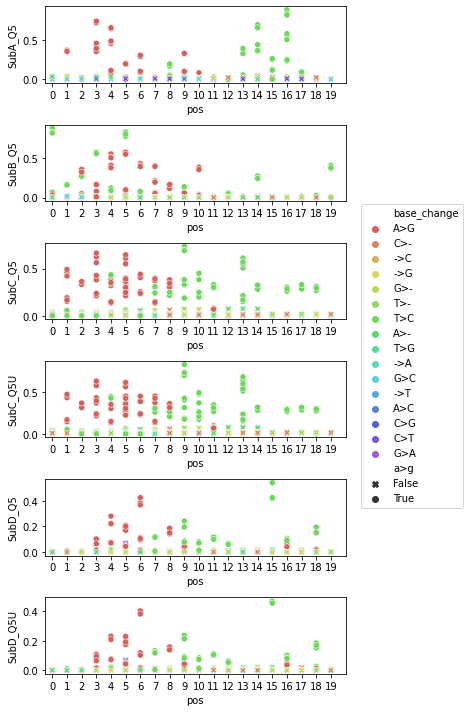

In [14]:
fig, ax = plt.subplots(6, 1, figsize=(5, 10))
for i, lib in enumerate(sublibraries):
    plot_pattern(endo_edit_rates, lib, ax[i], palette)
handles, labels = ax[0].get_legend_handles_labels()
n_legs = len(labels)//3
fig.legend(handles[:n_legs], labels[:n_legs], bbox_to_anchor=(1,0.5), loc="center left",)
plt.tight_layout()

All significant endogenous site edit is A>G. --> We will assign each edit to the guide with the correct strand direction.

In [15]:
endo_edit_rates_ag = {}
for s in sublibraries:
    endo_edit_rates_ag[s] = endo_edit_rates[s].loc[endo_edit_rates[s].base_change == "A>G"]

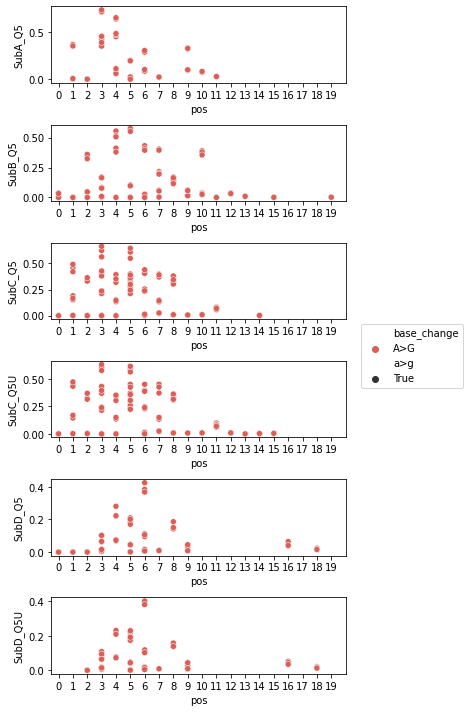

In [16]:
fig, ax = plt.subplots(6, 1, figsize=(5, 10))
for i, lib in enumerate(sublibraries):
    plot_pattern(endo_edit_rates_ag, lib, ax[i], palette)
handles, labels = ax[0].get_legend_handles_labels()
n_legs = len(labels)//3
fig.legend(handles[:n_legs], labels[:n_legs], bbox_to_anchor=(1,0.5), loc="center left",)
plt.tight_layout()

In [17]:
def filter_allele_for_cognate(allele):
    edits = []
    for e in allele.edits:
        if e.get_base_change() == "A>G":
            edits.append(e)
    return be.Allele(edits)

In [18]:
endo_allele_rates_ag = {}
for s in sublibraries:
    df = endo_allele_rates[s]
    df['allele'] = endo_allele_rates[s].allele.map(filter_allele_for_cognate)
    df = df.groupby(["guide", "allele"]).sum().reset_index()
    df = df.loc[df.allele.map(str)!=""]
    endo_allele_rates_ag[s] = df

# Compare endo vs reporter

## Edit level

Make single df for a library

In [19]:
def get_merged_results(endo_edit_rates, reporter_edit_rates, entity_str="edit"):
    merged = {}
    for s in sublibraries:
        endo_df = endo_edit_rates[s]
        endo_df = pd.wide_to_long(endo_df.iloc[:,:5], stubnames=f"{s}_rep", i = ["guide", entity_str], j = "rep").rename(columns={f"{s}_rep": "endo"}).reset_index()
        reporter_df = reporter_edit_rates[s]
        reporter_df.columns = reporter_df.columns[:2].tolist() + ["rep_1", "rep_2", "rep_3"]
        reporter_df = pd.wide_to_long(reporter_edit_rates[s], stubnames="rep_", i = ["guide", entity_str], j = "rep").rename(columns={"rep_": "reporter"}).reset_index()
        merged[s] = endo_df.merge(reporter_df, on=['guide', entity_str, 'rep'], how='outer').fillna(0)
    dfs = []
    for s in merged.keys():
        df = merged[s]
        df["lib"] = s
        dfs.append(df)
    edit_rates_merged = pd.concat(dfs, axis=0)
    return edit_rates_merged

In [20]:
edit_rates_merged = get_merged_results(endo_edit_rates_ag, reporter_edit_rates)

In [21]:
allele_rates_merged = get_merged_results(endo_allele_rates_ag, reporter_allele_rates, "allele")

In [9]:
#edit_rates_merged.to_csv("edit_rates.csv")

In [25]:
allele_rates_merged.to_csv("allele_rates.csv")

## Loading data

In [10]:
edit_rates_merged = pd.read_csv("edit_rates.csv")
allele_rates_merged = pd.read_csv("allele_rates.csv")

In [11]:
def filter_allele(allele, start=2, end=8):
    edit_list = []
    if not isinstance(allele, be.Allele):
        allele = be.Allele.from_str(allele)
    for edit in list(allele.edits):
        if (edit.pos >= start) & (edit.pos < end): edit_list.append(str(edit))
    return ",".join(edit_list)
    
allele_rates_merged["filtered_allele"] = allele_rates_merged.allele.map(filter_allele)

In [12]:
allele_rates_merged["filtered_allele_spacer"] = allele_rates_merged.allele.map(lambda s: filter_allele(s, 0, 19))
allele_rates_merged_spacer = allele_rates_merged.groupby(["guide", "rep", "lib", "filtered_allele_spacer"]).sum().reset_index()
allele_rates_merged_spacer['n_edits'] = allele_rates_merged_spacer.filtered_allele_spacer.map(lambda s: len(s.split(",")) if s != "" else 0)

<ipython-input-12-fc8b1435d407>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  allele_rates_merged_spacer = allele_rates_merged.groupby(["guide", "rep", "lib", "filtered_allele_spacer"]).sum().reset_index()


In [13]:
_allele_rates_merged = allele_rates_merged.groupby(["guide", "rep", "lib", "filtered_allele"]).sum().reset_index()

<ipython-input-13-df78b9b75d72>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  _allele_rates_merged = allele_rates_merged.groupby(["guide", "rep", "lib", "filtered_allele"]).sum().reset_index()


In [14]:
_allele_rates_merged.to_csv("_allele_rates_merged.csv")

In [15]:
_allele_rates_merged['n_edits'] = _allele_rates_merged.filtered_allele.map(lambda s: len(s.split(",")) if s != "" else 0)
allele_rates_merged['n_edits'] = allele_rates_merged.allele.map(lambda s: len(s.split(",")) if s != "" else 0)

In [17]:
edit_rates_merged['edit'] = edit_rates_merged.edit.map(lambda s:be.Edit.from_str(s))
edit_rates_merged['strand'] = edit_rates_merged.edit.map(lambda e: e.strand)
edit_rates_merged['pos'] = edit_rates_merged.edit.map(lambda e: e.pos)

In [18]:
cds = be.read_h5ad("../../results/filtered_annotated/LDLRCDS/bean_count_LDLRCDS_annotated2.h5ad")
acc = get_accessibility_guides("../../resources/accessibility/ENCFF262URW.hg19.bw", cds.guides)
cds.guides['accessibility'] = acc.numpy()

In [19]:
guides_acc = cds.guides[['accessibility', 'genomic_pos']].reset_index().rename(columns={'name':'guide'})
guides_acc.guide = guides_acc.guide.map(lambda s: s.replace("'", "_").replace(" ", "-").replace("+", "_"))

In [20]:
_edit_rates_merged = edit_rates_merged.merge(guides_acc, on='guide')

In [21]:
_edit_rates_merged['log_acc'] = np.log(_edit_rates_merged.accessibility)

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 maxp pruned 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 cmap pruned 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 kern dropped 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 post pruned 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 FFTM dropped 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 GPOS pruned 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 GSUB pruned 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 name pruned 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 glyf pruned 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 Added gid0 to subset 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 Added first four glyphs to subset 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 Closing glyph list over 'GSUB': 8 glyphs before 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'one', 'space', 'three', 'two', 'zero'] 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22] 

INFO  @ Sat, 19 Aug 2023 21:48:34:
	 Closed glyph list over 'GSUB': 8 glyphs after 

INFO  @ Sat, 19 Aug 

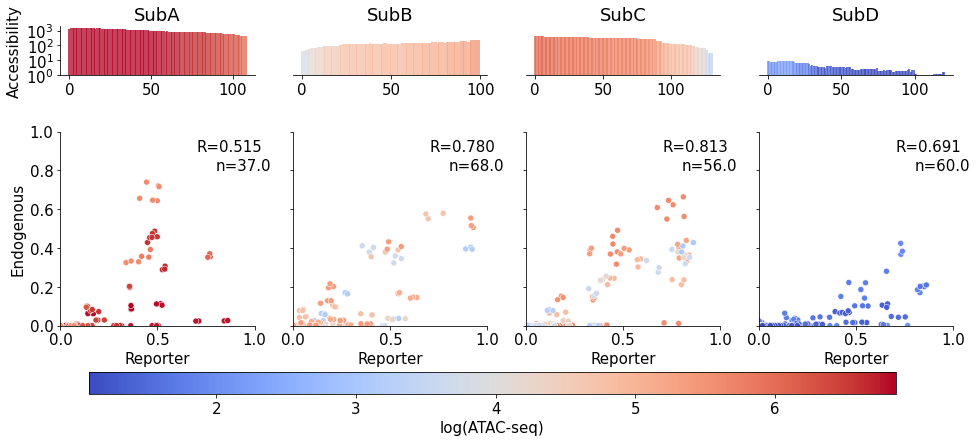

In [27]:
plt.style.use('jr')
fig, ax = plt.subplots(2,4, figsize=(16,6), gridspec_kw={'height_ratios': [1, 3]})

norm = plt.Normalize(_edit_rates_merged.log_acc.min(), _edit_rates_merged.log_acc.max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

for i, s in enumerate(["SubA_Q5", "SubB_Q5", "SubC_Q5", "SubD_Q5"]):
    pdf = _edit_rates_merged.loc[_edit_rates_merged.lib == s]
    pdf = pdf.sort_values("genomic_pos")
    xpts = list(range(0, int(pdf.genomic_pos.max() - pdf.genomic_pos.min()) + 1))
    accs = bwIn.values("chr19", int(pdf.genomic_pos.min()), int(pdf.genomic_pos.max()) + 1)
    ax[0, i].vlines(xpts, 0, accs, colors=[sm.to_rgba(a) for a in np.log(accs)])
    ax[0, i].set_yscale("log")
    ax[0, i].set_title(s.split("_")[0])
    ax[0, i].set_ylim((1,max(_edit_rates_merged.accessibility)*2))
    ax[0, i].set_box_aspect(0.25)
    if i == 0:
        ax[0, i].set_yticks([1, 10, 100, 1000])
        ax[0, i].spines[['right', 'top']].set_visible(False)
        ax[0, i].set_ylabel("Accessibility")
    else:
        ax[0, i].spines[['right', 'top', 'left']].set_visible(False)
        ax[0, i].tick_params(left = False, labelleft = False)
    
    sns.scatterplot(pdf, x='reporter', y = 'endo', hue='log_acc', ax=ax[1, i], palette='coolwarm', linewidth=0.5, hue_norm=(_edit_rates_merged.log_acc.min(), _edit_rates_merged.log_acc.max()), )
    ax[1, i].text(0.7, 0.9, f'R={_edit_rates_merged.loc[_edit_rates_merged.lib == s, ["reporter", "endo"]].corr().iloc[0, 1]:.3f}')
    ax[1, i].text(0.8, 0.8, f'n={len(_edit_rates_merged.loc[_edit_rates_merged.lib == s])/3}')
    ax[1, i].get_legend().remove()
    ax[1, i].spines[['right', 'top']].set_visible(False)
    if i == 0:
        ax[1, i].set_ylabel("Endogenous")
    else:
        ax[1, i].set_ylabel("")
        ax[1, i].tick_params(labelleft = False)
        


ax2 = fig.add_axes([0.15, 0, 0.7, 0.05])
cbar = fig.colorbar(sm, cax = ax2, location='bottom', shrink=0.3, label='log(ATAC-seq)')

for _ in ax:
    for _ax in _:
        _ax.set_anchor('W')

plt.setp(ax[1,:], xlim=(0,1), ylim=(0,1), xticks=[0, 0.5, 1], aspect=1, xlabel="Reporter")
#plt.tight_layout()
fig.savefig("2b_edit_rate_with_acc_signal.pdf", bbox_inches='tight')

#### Color by edit ID

In [23]:
_edit_rates_merged['edit_id'] = _edit_rates_merged['guide'] + _edit_rates_merged['edit'].astype(str)

<ipython-input-47-a73b61955381>:9: UserWarning: 
The palette list has fewer values (25) than needed (37) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(_edit_rates_merged.loc[_edit_rates_merged.lib == s], x='reporter', y = 'endo', hue='edit_id', ax=ax[i], palette=palette, linewidth=0.5, )
<ipython-input-47-a73b61955381>:9: UserWarning: 
The palette list has fewer values (25) than needed (68) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(_edit_rates_merged.loc[_edit_rates_merged.lib == s], x='reporter', y = 'endo', hue='edit_id', ax=ax[i], palette=palette, linewidth=0.5, )
<ipython-input-47-a73b61955381>:9: UserWarning: 
The palette list has fewer values (25) than needed (56) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(_edit_rates_merged.loc[_edit_rates_merged.lib == s], x='reporter', y = 'endo', hue='edit_id', ax=ax[i], palette=palette, linewidth=0.5, )
<ipython-input-47-a73b61955381>:9: UserW

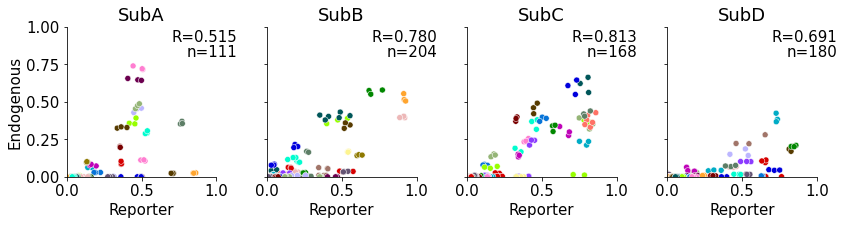

In [47]:
fig, ax = plt.subplots(1,4, figsize=(12,4), sharey=True)

# Setting palette with many colors
# https://stackoverflow.com/questions/68209351/how-to-make-a-color-map-with-many-unique-colors-in-seaborn
blobs, labels = make_blobs(n_samples=1000, centers=25, center_box=(-100, 100))
palette = sns.color_palette(cc.glasbey, n_colors=25)

for i, s in enumerate(["SubA_Q5", "SubB_Q5", "SubC_Q5", "SubD_Q5"]):
    sns.scatterplot(_edit_rates_merged.loc[_edit_rates_merged.lib == s], x='reporter', y = 'endo', hue='edit_id', ax=ax[i], palette=palette, linewidth=0.5, )
    ax[i].text(0.7, 0.9, f'R={_edit_rates_merged.loc[_edit_rates_merged.lib == s, ["reporter", "endo"]].corr().iloc[0, 1]:.3f}')
    ax[i].text(0.8, 0.8, f'n={len(_edit_rates_merged.loc[_edit_rates_merged.lib == s])}')
    ax[i].get_legend().remove()
    ax[i].set_title(s.split("_")[0])
    ax[i].spines[['right', 'top']].set_visible(False)

plt.setp(ax, xlim=(0,1), ylim=(0,1), aspect=1, ylabel='Endogenous', xlabel="Reporter")
plt.tight_layout()
fig.savefig("2b_edit_rate_acc_replication.pdf", bbox_inches='tight')

#### Color by strand

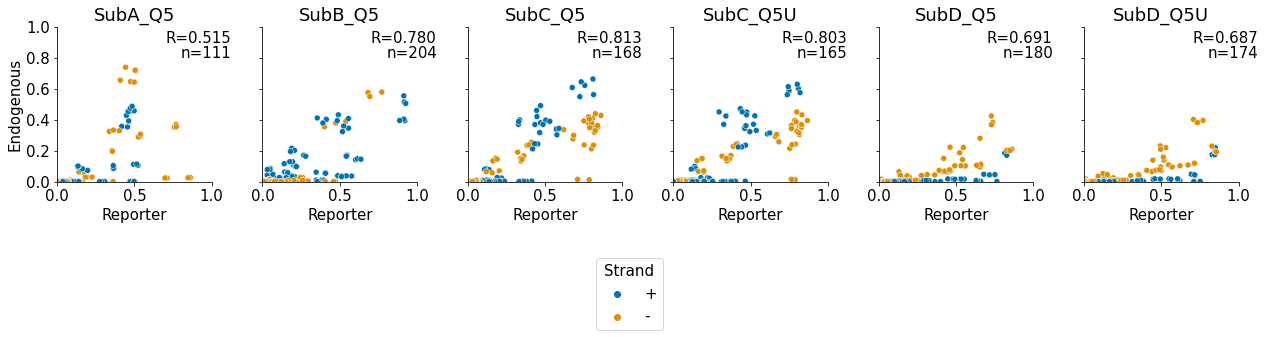

In [48]:
fig, ax = plt.subplots(1,6, figsize=(18,4), sharey=True)

for i, s in enumerate(["SubA_Q5", "SubB_Q5", "SubC_Q5", "SubC_Q5U", "SubD_Q5", "SubD_Q5U"]):
    sns.scatterplot(_edit_rates_merged.loc[_edit_rates_merged.lib == s], x='reporter', y = 'endo', hue='strand', ax=ax[i], palette='colorblind')
    ax[i].text(0.7, 0.9, f'R={_edit_rates_merged.loc[_edit_rates_merged.lib == s, ["reporter", "endo"]].corr().iloc[0, 1]:.3f}')
    ax[i].text(0.8, 0.8, f'n={len(_edit_rates_merged.loc[_edit_rates_merged.lib == s])}')
    ax[i].get_legend().remove()
    ax[i].set_title(s)
    ax[i].spines[['right', 'top']].set_visible(False)

handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], title="Strand", loc='upper center', bbox_to_anchor=(0.5, 0))
plt.setp(ax, xlim=(0,1), ylim=(0,1), aspect=1, ylabel='Endogenous', xlabel="Reporter")
plt.tight_layout()
fig.savefig("2b_edit_rate_acc_strand.pdf", bbox_inches='tight')

In [24]:
_edit_rates_merged.to_csv("1d_edit_rates_merged.csv")